In [1]:
from preprocessing import load_folder_paths, load_dcm_datasets, get_volume
from scipy import ndimage
import matplotlib.pyplot as plt

paths = load_folder_paths()

v = get_volume(paths[13], extract_brain=False, windowing=True, correct_motion=False, spatial_downsampling_factor=2, temporal_downsampling_factor=7)
v1 = v[0]
v2 = v[1]
v_smoothed = ndimage.gaussian_filter(v1, sigma=1.0)

Loading /Users/simonma/Desktop/UniToBrain/MOL-100...
Dicom files loaded, count: 288
Processing /Users/simonma/Desktop/UniToBrain/MOL-100...
5 [0.488281, 0.488281]


ic| window_center: 40, window_width: 80
ic| volume_seq.max(): 80.0
    volume_seq.min(): 0.0
    volume_seq.dtype: dtype('float32')


Done!


In [2]:
import numpy as np
import SimpleITK as sitk


In [65]:
from ipywidgets import interact, IntSlider

def overlay_volume_sequence_interactive(volume_seq):
    num_overlays = len(volume_seq) - 1
    nrows = max(1, int(num_overlays ** 0.5))
    ncols = (num_overlays + nrows - 1) // nrows
    print(f"{nrows=} {ncols=}")
    def plot_slice(slice_idx):

        fig, axes = plt.subplots(nrows, 
                                ncols, 
                                figsize=(5*ncols, 5*nrows),
                                squeeze=True)
        if nrows == 1:
            if ncols == 1:
                axes = [[axes]]
            else:
                axes = [axes]
        print(f"{axes=}")
        for i in range(num_overlays):
            ax = axes[i // ncols][i % ncols]
            print(f"{ax=}")
            ax.imshow(volume_seq[0][slice_idx], cmap="gray")
            ax.imshow(volume_seq[i+1][slice_idx], cmap="hot", alpha=0.3)
        plt.show(block=True)
    
    interact(
        plot_slice,
        slice_idx=IntSlider(
            min=0,
            max=len(volume_seq[0])-1, 
            step=1,
            value=0,
            description='Slice:'
        )
    )

def multi_vol_seq_interactive(volume_seqs, titles=None):
    """
    Interactive plot of multiple volume sequences using ipywidgets
    
    Parameters:
    - volume_seqs: List of 4D volume sequences to display
    - titles: Optional list of titles for each sequence
    """
    if titles is None:
        titles = [f"Volume {i+1}" for i in range(len(volume_seqs))]
        
    num_volumes = len(volume_seqs)
    nrows = int(num_volumes ** 0.5)
    ncols = (num_volumes + nrows - 1) // nrows
    
    def plot_volumes(time_idx, slice_idx):
        fig, axes = plt.subplots(nrows, ncols, 
                                figsize=(5*ncols, 5*nrows),
                                squeeze=True)
        if nrows == 1:
            if ncols == 1:
                axes = [[axes]]
            else:
                axes = [axes]
                
        for i, (volume_seq, title) in enumerate(zip(volume_seqs, titles)):
            row, col = i // ncols, i % ncols
            ax = axes[row][col]
            
            t = min(time_idx, len(volume_seq) - 1)
            s = min(slice_idx, len(volume_seq[t]) - 1)
            
            im = ax.imshow(volume_seq[t][s], cmap='magma')
            ax.set_title(title)
            plt.colorbar(im, ax=ax)
            
        plt.tight_layout()
        plt.show(block=True)
        
    max_time = max(len(vol) for vol in volume_seqs) - 1
    max_slice = max(len(vol[0]) for vol in volume_seqs) - 1
    
    interact(
        plot_volumes,
        time_idx=IntSlider(min=0, max=max_time, step=1, value=0, description='Time:'),
        slice_idx=IntSlider(min=0, max=max_slice, step=1, value=0, description='Slice:')
    )



In [63]:
multi_vol_seq_interactive([v, v])

interactive(children=(IntSlider(value=0, description='Time:', max=1), IntSlider(value=0, description='Slice:',…

In [ ]:
overlay_volume_sequence_interactive(v)

In [94]:
from IPython.display import clear_output
# Callback invoked when the StartEvent happens, sets up our new data.
def start_plot():
    global metric_values, multires_iterations

    metric_values = []
    multires_iterations = []


# Callback invoked when the EndEvent happens, do cleanup of data and figure.
def end_plot():
    global metric_values, multires_iterations

    del metric_values
    del multires_iterations
    # Close figure, we don't want to get a duplicate of the plot latter on.
    plt.close()


# Callback invoked when the IterationEvent happens, update our data and display new figure.
def plot_values(registration_method):
    if registration_method.GetOptimizerIteration() % 10 == 0:
        global metric_values, multires_iterations

        metric_values.append(registration_method.GetMetricValue())
        # Clear the output area (wait=True, to reduce flickering), and plot current data
        clear_output(wait=True)
        # Plot the similarity metric values
        plt.plot(metric_values, "r")
        plt.plot(
            multires_iterations,
            [metric_values[index] for index in multires_iterations],
            "b*",
        )
        plt.xlabel("Iteration Number", fontsize=12)
        plt.ylabel("Metric Value", fontsize=12)
        plt.show()


# Callback invoked when the sitkMultiResolutionIterationEvent happens, update the index into the
# metric_values list.
def update_multires_iterations():
    global metric_values, multires_iterations
    multires_iterations.append(len(metric_values))

In [114]:
from time import time
from preprocessing import get_skull_mask
def register_volume_inplane_weighted(moving_volume: np.ndarray, reference_volume: np.ndarray, 
                      n_samples: int = 5, lr: float = 1.0, n_iters: int = 1000, multi_res: bool = False
                      ) -> np.ndarray:
    """
    Performs in-plane registration by:
    1. Sampling n evenly-spaced slices
    2. Performing 2D registration on each slice
    3. Averaging transformations weighted by their metric values
    4. Applying final transformation to entire volume
    
    Args:
        moving_volume: Volume to be registered (Y, Z, X)
        reference_volume: Reference volume (Y, Z, X)
        n_samples: Number of slices to sample for registration
        lr: Learning rate for registration
        n_iters: Number of iterations for registration
        spacing: Physical spacing of the volume (Y, Z, X)
    """
    Y, Z, X = moving_volume.shape
    
    # Sample slice indices evenly from center
    center_idx = Y // 2
    if n_samples == 1:
        slice_indices = np.array([center_idx])
    else:
        half_range = (Y // 4)
        slice_indices = np.linspace(center_idx - half_range, center_idx + half_range, n_samples, dtype=int)
    
    # Store transforms and their weights
    transforms = []
    metric_values = []

    def adapt_learning_rate(method):
        # Every 10 iterations, decrease lr by 5%
        if method.GetOptimizerIteration() % 10 == 0:
            method.SetOptimizerLearningRate(method.GetOptimizerLearningRate() * 0.95)
            print(f"Learning rate decreased to {method.GetOptimizerLearningRate():.4f}")

        
    # Register each sampled slice
    for slice_idx in slice_indices:
        print(f"Registering slice {slice_idx} of {Y}")
        # Get corresponding slices
        moving_slice = moving_volume[slice_idx]
        reference_slice = reference_volume[slice_idx]
        
        # Convert to SimpleITK images
        moving_image = sitk.GetImageFromArray(ndimage.gaussian_filter(moving_slice, sigma=1.0))
        reference_image = sitk.GetImageFromArray(ndimage.gaussian_filter(reference_slice, sigma=1.0))
        
        # Set 2D spacing
        moving_image.SetSpacing((1, 1))
        reference_image.SetSpacing((1, 1))
        
        # Initialize 2D transform
        initial_transform = sitk.CenteredTransformInitializer(
            reference_image,
            moving_image,
            sitk.Euler2DTransform(),
            sitk.CenteredTransformInitializerFilter.GEOMETRY
        )
        
        # Setup registration method
        registration_method = sitk.ImageRegistrationMethod()
        # registration_method.SetMetricAsMeanSquares()
        # Similarity metric settings
        registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=50)
        registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)
        registration_method.SetMetricSamplingPercentage(0.1)

        
        # Interpolator settings
        registration_method.SetInterpolator(sitk.sitkLinear)

        # Optimizer settings
        # registration_method.SetOptimizerAsGradientDescent(
        #     learningRate=lr,
        #     estimateLearningRate=sitk.ImageRegistrationMethod.EachIteration,
        #     numberOfIterations=n_iters,
        #     convergenceMinimumValue=1e-6,            
        #     convergenceWindowSize=10,
        #     maximumStepSizeInPhysicalUnits=4

        # )
        registration_method.SetOptimizerAsRegularStepGradientDescent(
            learningRate=lr,
            minStep=1e-6,
            numberOfIterations=n_iters,
            gradientMagnitudeTolerance=1e-6,
            relaxationFactor=0.5,
            maximumStepSizeInPhysicalUnits=4
        )
        
        # Add convergence monitoring
        # registration_method.SetOptimizerScalesFromIndexShift()
        
        if multi_res:
            registration_method.SetShrinkFactorsPerLevel(shrinkFactors=[2, 1])
            registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[0, 0])
            registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()
        
        registration_method.SetInitialTransform(initial_transform)
        
        registration_method.AddCommand(sitk.sitkStartEvent, start_plot)
        registration_method.AddCommand(sitk.sitkEndEvent, end_plot)
        registration_method.AddCommand(
            sitk.sitkMultiResolutionIterationEvent, update_multires_iterations
        )
        registration_method.AddCommand(
            sitk.sitkIterationEvent, lambda: plot_values(registration_method)
        )
        # registration_method.AddCommand(sitk.sitkIterationEvent, lambda: command_iteration(registration_method))

        try:
            final_transform = registration_method.Execute(reference_image, moving_image)
            metric_value = registration_method.GetMetricValue()
            print(f"Stopping condition: {registration_method.GetOptimizerStopConditionDescription()}")
            # Store transform parameters and weight
            params = final_transform.GetParameters()
            center = final_transform.GetCenter()
            transforms.append((params, center))
            metric_values.append(metric_value)
            
        except RuntimeError as e:
            print(f"Registration failed for slice {slice_idx}: {e}")
            continue
    
    if not transforms:
        print("No successful registrations - returning original volume")
        return moving_volume
    
    # Convert metric values to weights based on chosen scheme
    metric_values = np.array(metric_values)
    print(np.mean(metric_values))
    
    # The smaller the metric value, the more that transformation weighs into final transformation
    weights = 1 / (metric_values + 1e-10)
    
    # Normalize weights
    weights = weights / np.sum(weights)
    print(weights)
    # Compute weighted average transformation
    avg_angle = 0
    avg_tx = 0
    avg_ty = 0
    avg_cx = 0
    avg_cy = 0
    
    for (params, center), weight in zip(transforms, weights):
        avg_angle += params[0] * weight
        avg_tx += params[1] * weight
        avg_ty += params[2] * weight
        avg_cx += center[0] * weight
        avg_cy += center[1] * weight
    
    print(f"{avg_angle=:.4f} {avg_tx=:.4f} {avg_ty=:.4f} {avg_cx=:.4f} {avg_cy=:.4f}")

    # Create final average transform
    final_transform = sitk.Euler2DTransform()
    final_transform.SetAngle(avg_angle)
    final_transform.SetTranslation((avg_tx, avg_ty))
    final_transform.SetCenter((avg_cx, avg_cy))
    
    # Apply transform to each slice of moving volume
    registered_volume = np.zeros_like(moving_volume)
    for i in range(moving_volume.shape[0]):
        moving_slice = sitk.GetImageFromArray(moving_volume[i])
        registered_slice = sitk.Resample(
            moving_slice,
            reference_image,
            final_transform,
            sitk.sitkLinear,
            0.0,
            moving_slice.GetPixelID()
        )
        registered_volume[i] = sitk.GetArrayFromImage(registered_slice)

    return registered_volume

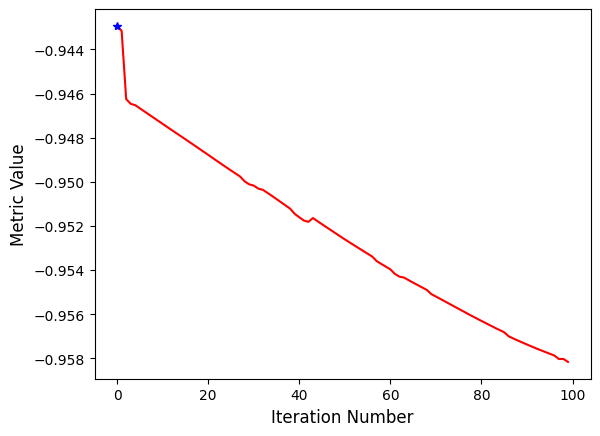

Stopping condition: RegularStepGradientDescentOptimizerv4: Maximum number of iterations (1000) exceeded.
-0.9439984793465662
[0.37392143 0.30036053 0.32571804]
avg_angle=-0.0034 avg_tx=-0.6047 avg_ty=0.0212 avg_cx=127.5000 avg_cy=127.5000


In [115]:
reg = register_volume_inplane_weighted(v2, v1, n_samples=3, lr=1, n_iters=1000)

In [116]:
overlay_volume_sequence_interactive([v1, reg, v2])

nrows=1 ncols=2


interactive(children=(IntSlider(value=0, description='Slice:', max=15), Output()), _dom_classes=('widget-inter…

In [108]:
multi_vol_seq_interactive([v, [v1, reg]])

interactive(children=(IntSlider(value=0, description='Time:', max=1), IntSlider(value=0, description='Slice:',…

In [15]:
np.square(reg - v1).mean()

204.35303

In [16]:
unwindowed = get_volume(paths[13], extract_brain=False, windowing=False, correct_motion=False, spatial_downsampling_factor=2, temporal_downsampling_factor=7)

Loading /Users/simonma/Desktop/UniToBrain/MOL-100...
Dicom files loaded, count: 288
Processing /Users/simonma/Desktop/UniToBrain/MOL-100...
5 [0.488281, 0.488281]
Done!


0.8778839111328125


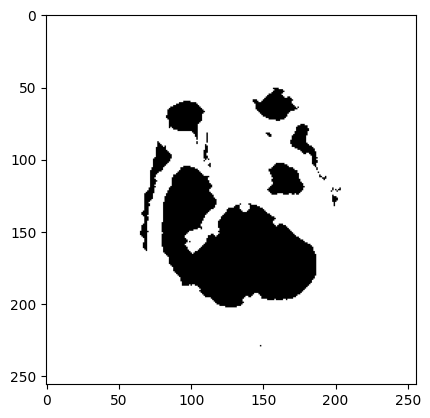

In [17]:
i = unwindowed[1][0]
# i = np.clip(i, -1024, 1000)
i = (i > -40) & (i < 120)
i = ndimage.binary_erosion(i, iterations=2)
i = ndimage.binary_fill_holes(i)
i = 1 - i
print(np.mean(i))
plt.imshow(i, cmap="gray")

In [18]:
volume_seq_2 = get_volume(paths[0], extract_brain=False, windowing=True, correct_motion=False, spatial_downsampling_factor=2, temporal_downsampling_factor=7)

Loading /Users/simonma/Desktop/UniToBrain/MOL-001...
Dicom files loaded, count: 288
Processing /Users/simonma/Desktop/UniToBrain/MOL-001...
5 [0.488281, 0.488281]


ic| window_center: 40, window_width: 80
ic| volume_seq.max(): 80.0
    volume_seq.min(): 0.0
    volume_seq.dtype: dtype('float32')


Done!


In [19]:
overlay_volume_sequence_interactive(volume_seq_2)

nrows=1 ncols=1


interactive(children=(IntSlider(value=0, description='Slice:', max=15), Output()), _dom_classes=('widget-inter…

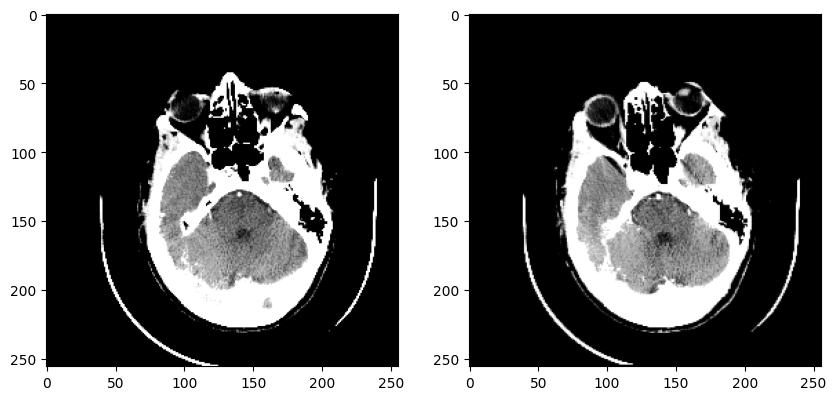

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(v1[0], cmap="gray")
ax[1].imshow(reg[0], cmap="gray")
plt.show()

In [21]:
volume_seq_2 = get_volume(paths[130], extract_brain=False, windowing=True, correct_motion=False, spatial_downsampling_factor=2, temporal_downsampling_factor=7)

Loading /Users/simonma/Desktop/UniToBrain/MOL-252...
Dicom files loaded, count: 288
Processing /Users/simonma/Desktop/UniToBrain/MOL-252...
5 [0.488281, 0.488281]


ic| window_center: 40, window_width: 80
ic| volume_seq.max(): 80.0
    volume_seq.min(): 0.0
    volume_seq.dtype: dtype('float32')


Done!


In [22]:
overlay_volume_sequence_interactive(volume_seq_2)

nrows=1 ncols=1


interactive(children=(IntSlider(value=0, description='Slice:', max=15), Output()), _dom_classes=('widget-inter…

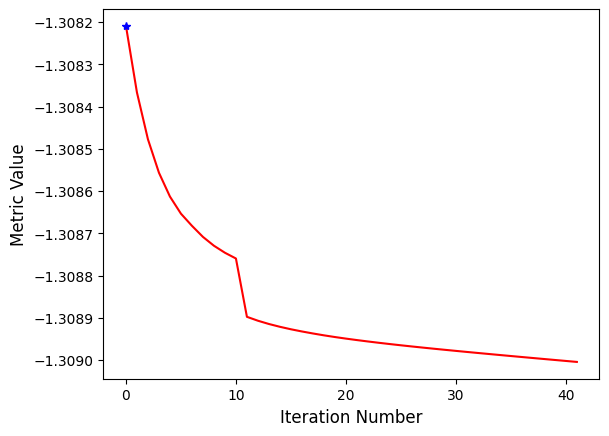

Stopping condition: GradientDescentOptimizerv4Template: Convergence checker passed at iteration 42.
-1.309006628957445
avg_angle=-0.0006 avg_tx=0.0006 avg_ty=-0.0002 avg_cx=127.5000 avg_cy=127.5000
nrows=1 ncols=1


interactive(children=(IntSlider(value=0, description='Slice:', max=15), Output()), _dom_classes=('widget-inter…

In [31]:
reg = register_volume_inplane_weighted(volume_seq_2[0], volume_seq_2[1], n_samples=1, lr=1e-4, n_iters=500)
overlay_volume_sequence_interactive([volume_seq_2[0], reg])

## An registration framwork based on MSE

In [131]:
def register_2(moving_volume: np.ndarray, reference_volume: np.ndarray, n_samples: int = 5, lr: float = 1.0, 
               n_iters: int = 1000, weighting_scheme: str = 'inverse', spacing: tuple = (1, 1)):
    Y, Z, X = moving_volume.shape
    
    # Sample slice indices evenly   
    slice_indices = np.linspace(Y//4, 3*Y//4, n_samples, dtype=int)
    
    # Store transforms and their weights
    transforms = []
    metric_values = []

    def command_iteration(method):
        if (method.GetOptimizerIteration() + 1) % 50 == 0:
            print(f"Iteration: {method.GetOptimizerIteration()}")
            print(f"Metric value: {method.GetMetricValue():.4f}")
                
    # Register each sampled slice
    for slice_idx in slice_indices:
        # print(f"Registering slice {slice_idx} of {Y}")
        # Get corresponding slices
        moving_slice = moving_volume[slice_idx]
        reference_slice = reference_volume[slice_idx]
        
        # Convert to SimpleITK images
        moving_image = sitk.GetImageFromArray(moving_slice)
        reference_image = sitk.GetImageFromArray(reference_slice)
        
        # Set 2D spacing
        moving_image.SetSpacing(spacing)
        reference_image.SetSpacing(spacing)
        
        # Create smoothed versions for registration
        smoothed_moving = sitk.DiscreteGaussian(moving_image, 1.0)
        smoothed_reference = sitk.DiscreteGaussian(reference_image, 1.0)
        
        # Initialize 2D transform
        initial_transform = sitk.CenteredTransformInitializer(
            smoothed_reference,
            smoothed_moving,
            sitk.Euler2DTransform(),
            sitk.CenteredTransformInitializerFilter.GEOMETRY
        )
        
        # Setup registration method
        registration_method = sitk.ImageRegistrationMethod()
        registration_method.SetMetricAsMeanSquares()
        registration_method.SetOptimizerAsRegularStepGradientDescent(
            learningRate=lr,
            minStep=1e-4,
            numberOfIterations=n_iters,
            gradientMagnitudeTolerance=1e-6,
            
        )

        registration_method.SetInitialTransform(initial_transform)
        registration_method.SetInterpolator(sitk.sitkLinear)
        
        registration_method.AddCommand(sitk.sitkIterationEvent, lambda: command_iteration(registration_method))
        registration_method.AddCommand(sitk.sitkStartEvent, start_plot)
        registration_method.AddCommand(sitk.sitkEndEvent, end_plot)
        registration_method.AddCommand(
            sitk.sitkMultiResolutionIterationEvent, update_multires_iterations
        )
        registration_method.AddCommand(
            sitk.sitkIterationEvent, lambda: plot_values(registration_method)
        )
        try:
            final_transform = registration_method.Execute(smoothed_reference, smoothed_moving)
            metric_value = registration_method.GetMetricValue()
            print(f"Stopping condition: {registration_method.GetOptimizerStopConditionDescription()}")
            print(f"Metric value: {metric_value:.4f}")
            # Store transform parameters and weight
            params = final_transform.GetParameters()
            center = final_transform.GetCenter()
            transforms.append((params, center))
            metric_values.append(metric_value)
            
        except RuntimeError as e:
            print(f"Registration failed for slice {slice_idx}: {e}")
            continue
    
    if not transforms:
        print("No successful registrations - returning original volume")
        return moving_volume
    
    # Convert metric values to weights based on chosen scheme
    metric_values = np.array(metric_values)
    print(metric_values)

    if weighting_scheme == 'inverse':
        # Original inverse weighting
        weights = 1.0 / (metric_values + 1e-10)

    elif weighting_scheme == 'inverse_root':
        weights = 1.0 / (np.sqrt(metric_values) + 1e-10)
    
    elif weighting_scheme == 'exponential':
        # Exponential decay: w = exp(-metric_value)
        # More robust to outliers than inverse
        weights = np.exp(-metric_values)
    
    elif weighting_scheme == 'softmax':
        # Softmax-based weighting: emphasizes better matches while maintaining non-zero weights
        # Negative because lower metric values are better
        weights = np.exp(-metric_values) / np.sum(np.exp(-metric_values))
        
    elif weighting_scheme == 'rank':
        # Rank-based weighting: less sensitive to absolute metric values
        ranks = np.argsort(np.argsort(-metric_values))  # Higher rank for lower metric value
        weights = 1.0 / (ranks + 1)
    
    elif weighting_scheme == 'threshold':
        # Threshold-based: only keep transforms with metric values below mean
        mean_metric = np.mean(metric_values)
        weights = np.where(metric_values < mean_metric, 1.0, 0.0)
        if np.sum(weights) == 0:  # If all transforms are above mean
            weights = np.ones_like(metric_values)
    
    # Normalize weights
    weights = weights / np.sum(weights)
    
    # Compute weighted average transformation
    avg_angle = 0
    avg_tx = 0
    avg_ty = 0
    avg_cx = 0
    avg_cy = 0
    
    for (params, center), weight in zip(transforms, weights):
        avg_angle += params[0] * weight
        avg_tx += params[1] * weight
        avg_ty += params[2] * weight
        avg_cx += center[0] * weight
        avg_cy += center[1] * weight
    
    print(f"{avg_angle=:.4f} {avg_tx=:.4f} {avg_ty=:.4f} {avg_cx=:.4f} {avg_cy=:.4f}")


    # Precompute trig values
    cos_theta = np.cos(avg_angle)
    sin_theta = np.sin(avg_angle)

    # Build affine matrix once
    affine_matrix = np.array([
        [cos_theta, -sin_theta, avg_tx + avg_cx - avg_cx*cos_theta + avg_cy*sin_theta],
        [sin_theta, cos_theta, avg_ty + avg_cy - avg_cx*sin_theta - avg_cy*cos_theta],
        [0, 0, 1]
    ])

    # # Extract transformation components
    # transform_matrix = affine_matrix[:2, :2]
    # offset = affine_matrix[:2, 2]
    # # Apply transform to entire volume slice by slice
    # registered_volume = np.zeros_like(moving_volume)
    # t1 = time()
    # for y in range(Y):
    #     registered_volume[y] = ndimage.affine_transform(
    #         moving_volume[y],
    #         transform_matrix,
    #         offset=offset,
    #         output_shape=moving_volume[y].shape,
    #         order=1
    #     )
    # print(f"Time taken: {time() - t1}")
        # Create final average transform
    final_transform = sitk.Euler2DTransform()
    final_transform.SetAngle(avg_angle)
    final_transform.SetTranslation((avg_tx, avg_ty))
    final_transform.SetCenter((avg_cx, avg_cy))
    
    # Apply transform to each slice of moving volume
    registered_volume = np.zeros_like(moving_volume)
    for i in range(moving_volume.shape[0]):
        moving_slice = sitk.GetImageFromArray(moving_volume[i])
        registered_slice = sitk.Resample(
            moving_slice,
            reference_image,
            final_transform,
            sitk.sitkLinear,
            0.0,
            moving_slice.GetPixelID()
        )
        registered_volume[i] = sitk.GetArrayFromImage(registered_slice)

    return registered_volume

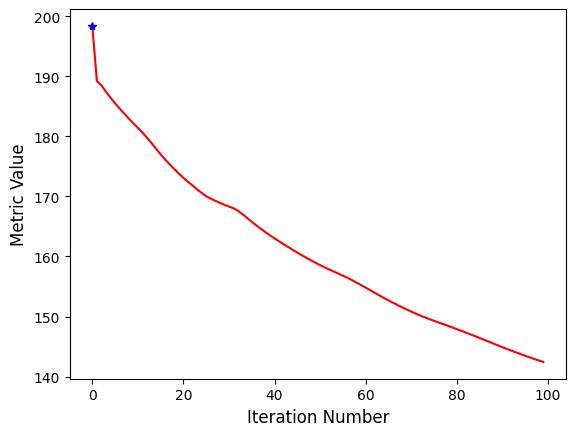

Iteration: 999
Metric value: 142.1344
Stopping condition: RegularStepGradientDescentOptimizerv4: Maximum number of iterations (1000) exceeded.
Metric value: 142.1344
[142.13440147]
avg_angle=-0.0226 avg_tx=-2.2137 avg_ty=-0.3850 avg_cx=127.5000 avg_cy=127.5000
Time taken: 0.026000261306762695


In [122]:
reg_2 = register_2(v2, v1, n_samples=1, lr=1, n_iters=1000, weighting_scheme='inverse')


In [123]:
overlay_volume_sequence_interactive([v1, reg_2])

nrows=1 ncols=1


interactive(children=(IntSlider(value=0, description='Slice:', max=15), Output()), _dom_classes=('widget-inter…

In [70]:
multi_vol_seq_interactive([v, [v1, reg_2]])

interactive(children=(IntSlider(value=0, description='Time:', max=1), IntSlider(value=0, description='Slice:',…

In [ ]:
import os
dataset_path = os.path.expanduser('~/Desktop/UniToBrain')
path = os.path.join(dataset_path, 'MOL-112')


## Let's try registration without windowing

In [79]:
v_raw = get_volume(paths[13], extract_brain=False, windowing=False, correct_motion=False, spatial_downsampling_factor=2, temporal_downsampling_factor=7)

Loading /Users/simonma/Desktop/UniToBrain/MOL-100...
Dicom files loaded, count: 288
Processing /Users/simonma/Desktop/UniToBrain/MOL-100...
5 [0.488281, 0.488281]
Done!


In [80]:
from preprocessing import apply_window
v_raw = apply_window(v_raw, window_center=0, window_width=2000)

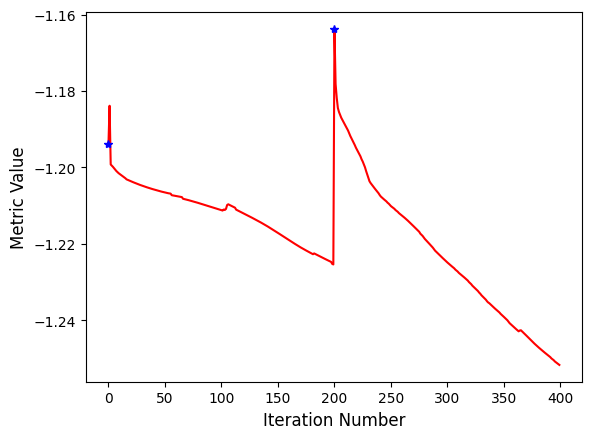

Stopping condition: RegularStepGradientDescentOptimizerv4: Maximum number of iterations (2000) exceeded.
-1.251976883608474
avg_angle=-0.0202 avg_tx=-1.8594 avg_ty=0.2374 avg_cx=127.5000 avg_cy=127.5000


In [100]:
reg_raw = register_volume_inplane_weighted(v_raw[1], v_raw[0], n_samples=1, lr=1, n_iters=2000, multi_res=True)

In [101]:
multi_vol_seq_interactive([v_raw, [v_raw[0], reg_raw]])

interactive(children=(IntSlider(value=0, description='Time:', max=1), IntSlider(value=0, description='Slice:',…

## This Scan is too corrupted to use

In [127]:
import os
dataset_path = os.path.expanduser('~/Desktop/UniToBrain')
path = os.path.join(dataset_path, 'MOL-133')
v_133 = get_volume(path, extract_brain=False, windowing=True, correct_motion=False, spatial_downsampling_factor=2, temporal_downsampling_factor=7)

Loading /Users/simonma/Desktop/UniToBrain/MOL-133...
Dicom files loaded, count: 288
Processing /Users/simonma/Desktop/UniToBrain/MOL-133...
5 [0.488281, 0.488281]


ic| window_center: 40, window_width: 80
ic| volume_seq.max(): 80.0
    volume_seq.min(): 0.0
    volume_seq.dtype: dtype('float32')


Done!


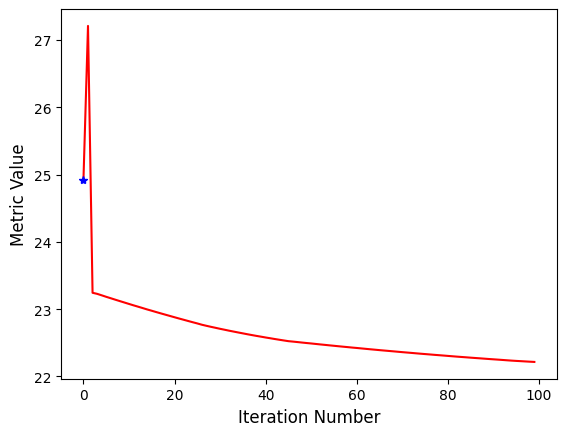

Iteration: 999
Metric value: 22.2149
Stopping condition: RegularStepGradientDescentOptimizerv4: Maximum number of iterations (1000) exceeded.
Metric value: 22.2149
[22.21494061]
avg_angle=0.0069 avg_tx=0.2292 avg_ty=0.0665 avg_cx=127.5000 avg_cy=127.5000


In [132]:
reg_133 = register_2(v_133[1], v_133[0], n_samples=1, lr=1, n_iters=1000, weighting_scheme='inverse')

In [133]:
multi_vol_seq_interactive([v_133, [v_133[0], reg_133]])

interactive(children=(IntSlider(value=0, description='Time:', max=1), IntSlider(value=0, description='Slice:',…

This works! Notice the rotation correction from t=0 to t=1

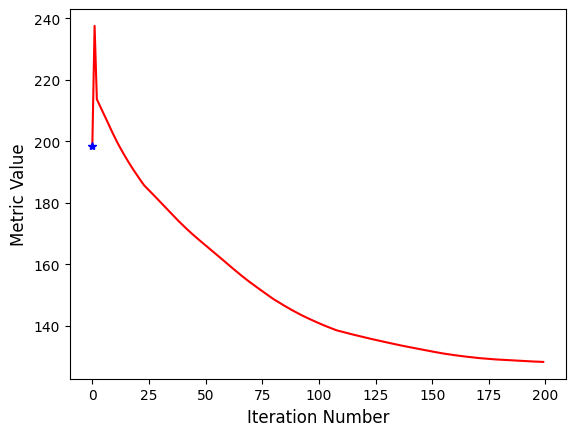

Iteration: 1999
Metric value: 128.2972
Stopping condition: RegularStepGradientDescentOptimizerv4: Maximum number of iterations (2000) exceeded.
Metric value: 128.2972
[128.29719753]
avg_angle=6.2367 avg_tx=-3.4647 avg_ty=-0.1370 avg_cx=127.5000 avg_cy=127.5000


interactive(children=(IntSlider(value=0, description='Time:', max=1), IntSlider(value=0, description='Slice:',…

In [136]:
# Let's try this on the previous scan
v_100_reg2 = register_2(v[1], v[0], n_samples=1, lr=5, n_iters=2000, weighting_scheme='inverse')
multi_vol_seq_interactive([v, [v[0], v_100_reg2]])

My goodness this works too, I've spent wayyy to much time on this simple registration task

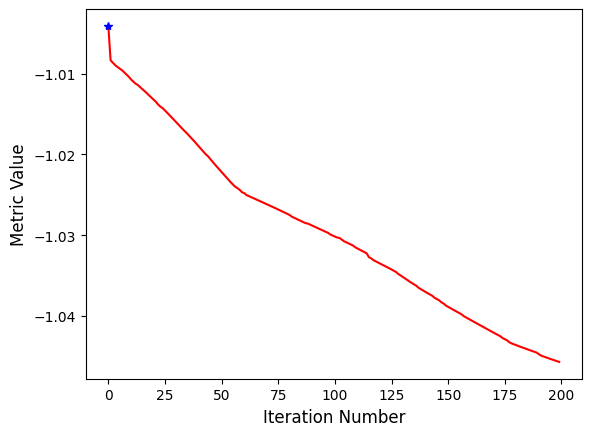

Stopping condition: RegularStepGradientDescentOptimizerv4: Maximum number of iterations (2000) exceeded.
-1.0456991904828097
[1.]
avg_angle=-0.0054 avg_tx=-0.6301 avg_ty=0.0646 avg_cx=127.5000 avg_cy=127.5000


In [139]:
v_100_reg1 = register_volume_inplane_weighted(v[1], v[0], n_samples=1, lr=1e-3, n_iters=2000)